In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [2]:
# The dataset contains 2019 observations and 9 columns.
file_path = "..\data\ALGO_daily.csv"
df = pd.read_csv(file_path)
df.set_index(df.columns[0], inplace=True)
df.head()

,open,high,low,close,return,return2,RV,lnRV,lnRV_lag7,lnRV_lag30,lnRV_lag60
timestamp,,,,,,,,,,,
2019-08-21,0.626,0.627,0.559,0.567,-0.097392,0.009485,0.005644,-5.177089,-5.120973,-4.842265,-4.657151
2019-08-22,0.567,0.592,0.531,0.572,0.008780,0.000077,0.006631,-5.015983,-5.232313,-4.847512,-4.692676
2019-08-23,0.573,0.589,0.546,0.576,0.006969,0.000049,0.005480,-5.206578,-5.275639,-4.863660,-4.711858
2019-08-24,0.574,0.580,0.542,0.577,0.001735,0.000003,0.003904,-5.545689,-5.270696,-4.876759,-4.737760
2019-08-25,0.578,0.582,0.530,0.538,-0.069984,0.004898,0.004892,-5.320139,-5.283678,-4.883515,-4.777490


In [3]:
# Train-Test Split (80% train, 20% test)
train_size = int(0.8 * len(df))
test_size = len(df) - train_size
r_train, r_test = df['return'][:train_size], df['return'][train_size:]
RV_train, RV_test = df['RV'][:train_size], df['RV'][train_size:]

print("Training Set:", r_train.shape, RV_train.shape)
print("Test Set:", r_test.shape, RV_test.shape)
print(r_train.index[0], r_test.index[0])

Training Set: (1615,) (1615,)
Test Set: (404,) (404,)
2019-08-21 2024-01-22


### Box-Jenkins

#### ACF & PACF

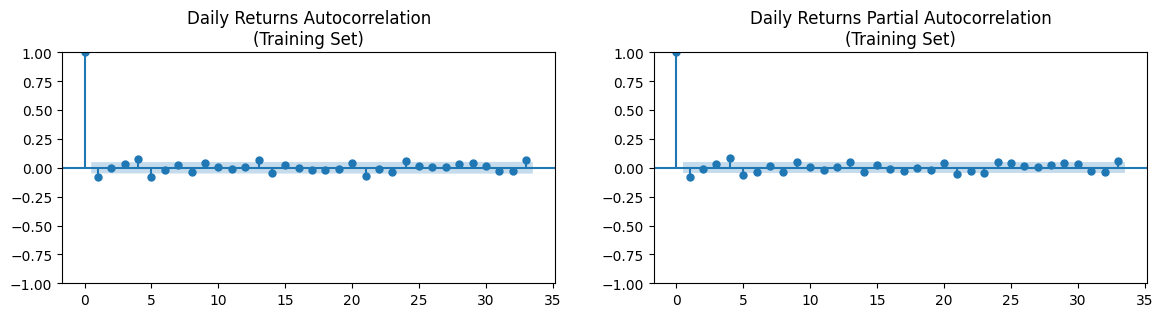

In [4]:
# ACF and PACF plots of returns
fig, ax = plt.subplots(1, 2, figsize=(14, 3))
plot_acf(r_train, title='Daily Returns Autocorrelation\n(Training Set)', ax=ax[0])
plot_pacf(r_train, title='Daily Returns Partial Autocorrelation\n(Training Set)', ax=ax[1])
plt.show()

### ARMA

In [ ]:
# AR(1) Model


### ARCH Framework

$$ r_t = \mu + \epsilon_t， \epsilon_t = z_t \sigma_t \\
\sigma_t^2 = \omega + \sum^p_{i=1}\alpha_i \epsilon_{t-1}^2 $$

where $r_t$ is the return series with its mean $\mu$, $\epsilon_t$ the error term and $\sigma_t^2$ the conditional variance. 

$z_t$ is assumed to be an I.I.D. process with $z_t \sim \mathcal{N}(0,1)$. 

To impose that the conditional variance is always nonnegative the parametric constraints are $\omega > 0$ and $\alpha_i \geq 0$. 

The ARCH model is a symmetric model, which implies that a positive shock has the same influence on the conditional variance as a negative shock of the same size.



In [5]:
# get five equally spaced dates from the index of training set
xtick_dates = r_train.index[::len(r_train)//5]

# add the last date to the list
xtick_dates = xtick_dates.append(r_train.index[-1:])
xtick_dates

Index(['2019-08-21', '2020-07-09', '2021-05-28', '2022-04-16', '2023-03-05',
       '2024-01-21'],
      dtype='object', name='timestamp')

In [6]:
def get_garch_fit(p, o, q, dist):
    return arch_model(r_train, p=p, o=o, q=q, rescale=False, dist=dist).fit(disp='off')

def plot_garch_fit(fit, vol_type):
    plt.figure(figsize=(8, 3))
    plt.plot(RV_train, color='black', label='Realized Volatility')
    plt.plot(fit.conditional_volatility, color='blue', label=''f'{vol_type} Conditional Volatility')
    plt.xticks(xtick_dates)
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.title(''f'{vol_type} Conditional Volatility vs Realized Volatility')
    plt.legend()
    plt.show()

#### ARCH(1)

##### Assume normal distribution of error

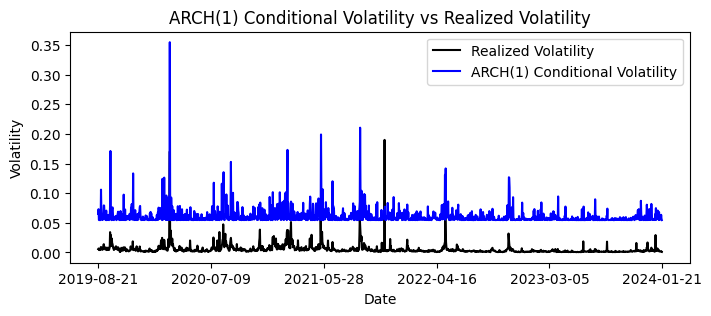

In [7]:
arch_1_fit = get_garch_fit(1, 0, 0, 'normal')
plot_garch_fit(arch_1_fit, 'ARCH(1)')

##### Assume student-t distribution of error

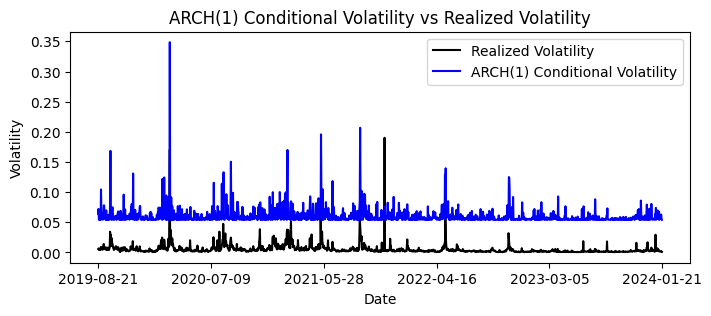

In [8]:
arch_1_fit = get_garch_fit(1, 0, 0, 'StudentsT')
plot_garch_fit(arch_1_fit, 'ARCH(1)')

### GARCH

An extended form of the ARCH(p) model is the generalized autoregressive conditional het
eroskedasticity (GARCH(p,q)) model by Bollerslev (1986).

$$ r_t = \mu + \epsilon_t， \epsilon_t = z_t \sigma_t \\
\sigma_t^2 = \omega + \sum^q_{i=1}\alpha_i \epsilon_{t-i}^2 + \sum^p_{j=1}\beta_j \sigma_{t-j}^2$$

The parametric restrictions for the GARCH model are: $\omega > 0$ and $\alpha_i \geq 0 $ $ \forall i$, $\beta_j \geq 0 $ $ \forall j$, to guarantee that $\sigma_t^2$ is always positive and $\alpha_i + \beta_j < 1 $ $ \forall i, j$ to guarantee a covariance stationary process. 

The GARCH model has a symmetric form similar to the ARCH model and therefore does
not allow for different responses to positive or negative shocks, which is considered as a
downside of the GARCH model.

#### GARCH(1,1)

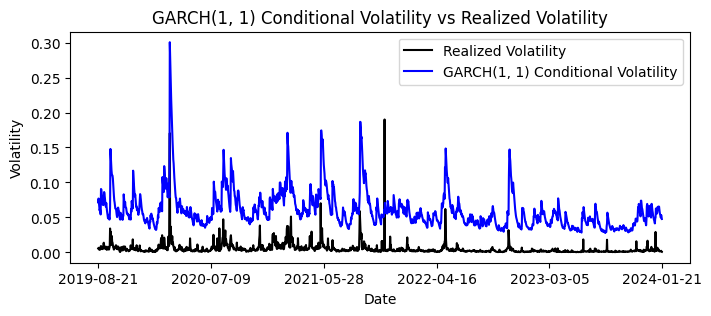

In [9]:
garch_1_1_fit = get_garch_fit(1, 0, 1, 'normal')
plot_garch_fit(garch_1_1_fit, 'GARCH(1, 1)')

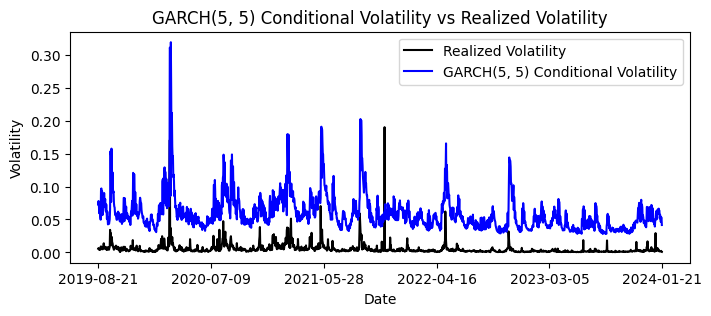

In [10]:
garch_5_5_fit = get_garch_fit(5, 0, 5, 'normal')
plot_garch_fit(garch_5_5_fit, 'GARCH(5, 5)')

### EGARCH


#### EGARCH(1,1,1)

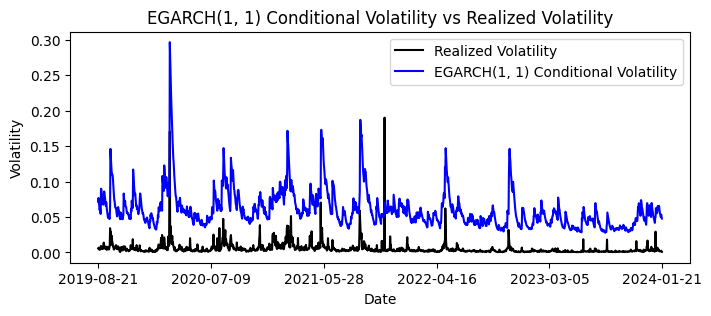

In [11]:
# egarch
egarch_1_1_fit = get_garch_fit(1, 1, 1, 'normal')
plot_garch_fit(egarch_1_1_fit, 'EGARCH(1, 1)')

### AIC & BIC

In [14]:
# save AIC and BIC values to a table

results = pd.DataFrame({
    'ARCH(1)': [arch_1_fit.aic, arch_1_fit.bic],
    'GARCH(1, 1)': [garch_1_1_fit.aic, garch_1_1_fit.bic],
    'GARCH(5, 5)': [garch_5_5_fit.aic, garch_5_5_fit.bic],
    'EGARCH(1, 1)': [egarch_1_1_fit.aic, egarch_1_1_fit.bic]
}, index=['AIC', 'BIC'])

results

,ARCH(1),"GARCH(1, 1)","GARCH(5, 5)","EGARCH(1, 1)"
AIC,-4791.237626,-4714.162047,-4743.654423,-4712.180825
BIC,-4769.689265,-4692.613686,-4679.009340,-4685.245374


In [15]:
# Choose the best model with the lowest AIC and BIC values
best_model = results.idxmin(axis=1)
best_model

AIC    ARCH(1)
BIC    ARCH(1)
dtype: object